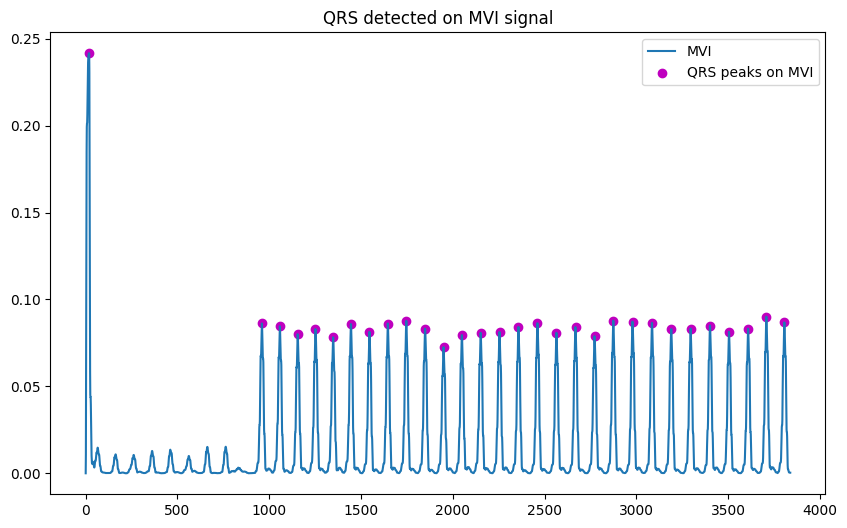

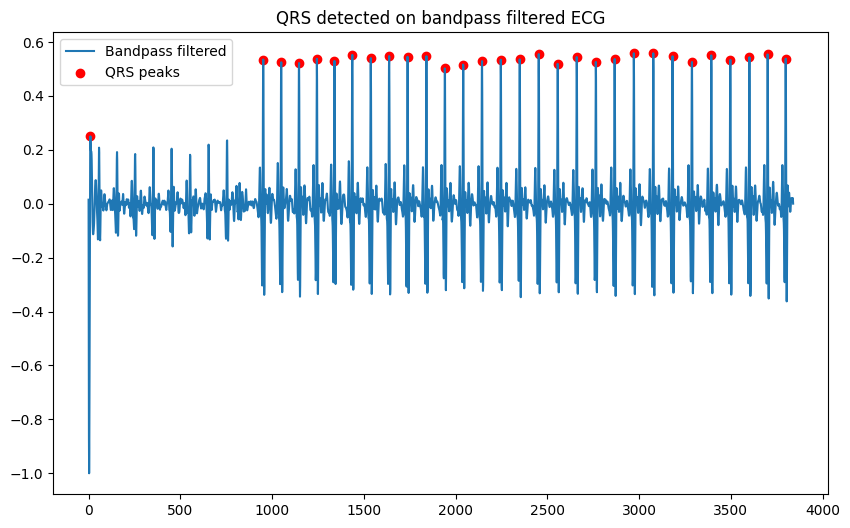

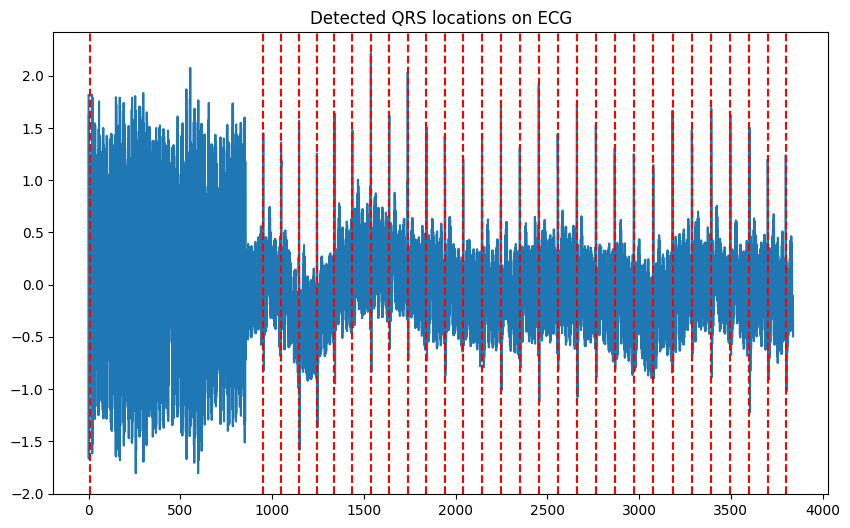

Detected 30 QRS complexes.
QRS Amplitudes: [0.2498265  0.53477232 0.52481952 0.52171631 0.53748999 0.52967126
 0.55190692 0.54007481 0.54764793 0.54505527 0.5472955  0.50195928
 0.51603795 0.52882016 0.53414604 0.53551387 0.55496689 0.51871185
 0.54400934 0.52580021 0.53675292 0.55806277 0.55798279 0.54685082
 0.52557974 0.55009338 0.53340735 0.54336521 0.55374496 0.53806562]
QRS Indices: [  10  952 1050 1147 1244 1340 1437 1538 1638 1738 1841 1941 2041 2144
 2246 2349 2453 2556 2660 2764 2867 2971 3077 3182 3288 3393 3497 3601
 3700 3799]
Filtering delay (samples): 9
R-R intervals (ms): [7359.375   765.625   757.8125  757.8125  750.      757.8125  789.0625
  781.25    781.25    804.6875  781.25    781.25    804.6875  796.875
  804.6875  812.5     804.6875  812.5     812.5     804.6875  812.5
  828.125   820.3125  828.125   820.3125  812.5     812.5     773.4375
  773.4375]


In [33]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks, convolve
import matplotlib.pyplot as plt
import os

def pan_tompkins(signal, fs, plot=False):
    ecg = np.ravel(signal)
    delay = 0
    skip = False
    ser_back = False

    ecg = ecg - np.mean(ecg)

    if fs == 200:
        Wn_low = 12 * 2 / fs
        b_low, a_low = butter(3, Wn_low, btype='lowpass')
        ecg_low = filtfilt(b_low, a_low, ecg)
        ecg_low /= np.max(np.abs(ecg_low))

        Wn_high = 5 * 2 / fs
        b_high, a_high = butter(3, Wn_high, btype='highpass')
        ecg_high = filtfilt(b_high, a_high, ecg_low)
        ecg_high /= np.max(np.abs(ecg_high))
    else:
        f_high, f_low = 5, 15
        Wn = [f_high * 2 / fs, f_low * 2 / fs]
        b, a = butter(3, Wn, btype='bandpass')
        ecg_high = filtfilt(b, a, ecg)
        ecg_high /= np.max(np.abs(ecg_high))

    if fs == 200:
        b_derivative = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
    else:
        x_old = np.arange(5)
        y_old = np.array([1, 2, 0, -2, -1]) * (1 / 8) * fs
        x_new = np.linspace(0, 4, int(fs / 40 * 4))
        b_derivative = np.interp(x_new, x_old, y_old)

    ecg_derivative = filtfilt(b_derivative, [1], ecg_high)
    ecg_derivative /= np.max(np.abs(ecg_derivative))

    ecg_squared = ecg_derivative ** 2

    window_size = int(round(0.150 * fs))
    ecg_mwi = convolve(ecg_squared, np.ones(window_size) / window_size, mode='full')[:len(ecg_squared)]
    delay += int(window_size / 2)

    min_distance = int(round(0.2 * fs))
    peaks, _ = find_peaks(ecg_mwi, distance=min_distance)

    LLp = len(peaks)
    qrs_amp = np.zeros(LLp)
    qrs_ind = np.zeros(LLp, dtype=int)
    qrs_raw_amp = np.zeros(LLp)
    qrs_raw_ind = np.zeros(LLp, dtype=int)
    noise_amp = np.zeros(LLp)
    noise_ind = np.zeros(LLp, dtype=int)

    THR_SIG = np.max(ecg_mwi[:2 * fs]) / 3.0
    THR_NOISE = np.mean(ecg_mwi[:2 * fs]) / 2.0
    SIG_LEV = THR_SIG
    NOISE_LEV = THR_NOISE

    THR_SIG1 = np.max(ecg_high[:2 * fs]) / 3.0
    THR_NOISE1 = np.mean(ecg_high[:2 * fs]) / 2.0
    SIG_LEV1 = THR_SIG1
    NOISE_LEV1 = THR_NOISE1

    Beats = 0
    Beats_raw = 0
    Noise_Count = 0
    mean_RR = 0
    m_selected_RR = 0

    for i in range(LLp):
        loc = peaks[i]
        window_start = max(0, loc - window_size)
        window_end = loc
        segment = ecg_high[window_start:window_end] if window_end > window_start else ecg_high[loc:loc+1]
        y_i = np.max(segment)
        x_i = np.argmax(segment) + window_start if len(segment) > 1 else loc

        if Beats >= 9:
            diffRR = np.diff(qrs_ind[Beats - 8:Beats])
            mean_RR = np.mean(diffRR)
            comp = qrs_ind[Beats - 1] - qrs_ind[Beats - 2] if Beats > 1 else 0
            if comp != 0 and (comp <= 0.92 * mean_RR or comp >= 1.16 * mean_RR):
                THR_SIG *= 0.5
                THR_SIG1 *= 0.5
            else:
                m_selected_RR = mean_RR

        test_m = m_selected_RR if m_selected_RR != 0 else mean_RR if mean_RR != 0 else 0

        if test_m and Beats > 0:
            if (loc - qrs_ind[Beats - 1]) >= int(1.66 * test_m):
                search_segment = ecg_mwi[qrs_ind[Beats - 1] + int(0.2 * fs):loc - int(0.2 * fs)]
                if len(search_segment) > 0:
                    local_max = np.argmax(search_segment)
                    loc_temp = qrs_ind[Beats - 1] + int(0.2 * fs) + local_max
                    pks_temp = search_segment[local_max]
                    if pks_temp > THR_NOISE:
                        Beats += 1
                        if Beats >= len(qrs_ind): break
                        qrs_amp[Beats - 1] = pks_temp
                        qrs_ind[Beats - 1] = loc_temp
                        w_start = max(0, loc_temp - window_size)
                        w_end = min(loc_temp, len(ecg_high))
                        segment2 = ecg_high[w_start:w_end]
                        if len(segment2) > 0:
                            y_i_t = np.max(segment2)
                            x_i_t = np.argmax(segment2) + w_start
                            if y_i_t > THR_NOISE1:
                                Beats_raw += 1
                                qrs_raw_amp[Beats_raw - 1] = y_i_t
                                qrs_raw_ind[Beats_raw - 1] = x_i_t
                                SIG_LEV1 = 0.25 * y_i_t + 0.75 * SIG_LEV1
                            SIG_LEV = 0.25 * pks_temp + 0.75 * SIG_LEV

        if ecg_mwi[loc] >= THR_SIG:
            if Beats >= 3 and (loc - qrs_ind[Beats - 1]) <= int(0.36 * fs):
                slope1 = np.mean(np.diff(ecg_mwi[loc - int(0.075 * fs):loc]))
                slope2 = np.mean(np.diff(ecg_mwi[qrs_ind[Beats - 1] - int(0.075 * fs):qrs_ind[Beats - 1]]))
                if np.abs(slope1) <= 0.5 * np.abs(slope2):
                    Noise_Count += 1
                    if Noise_Count < LLp:
                        noise_amp[Noise_Count - 1] = ecg_mwi[loc]
                        noise_ind[Noise_Count - 1] = loc
                    skip = True
                    NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
                    NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV
                else:
                    skip = False
            if not skip:
                Beats += 1
                if Beats > LLp: break
                qrs_amp[Beats - 1] = ecg_mwi[loc]
                qrs_ind[Beats - 1] = loc
                if y_i >= THR_SIG1:
                    Beats_raw += 1
                    if Beats_raw > LLp: break
                    qrs_raw_ind[Beats_raw - 1] = x_i
                    qrs_raw_amp[Beats_raw - 1] = y_i
                    SIG_LEV1 = 0.125 * y_i + 0.875 * SIG_LEV1
                SIG_LEV = 0.125 * ecg_mwi[loc] + 0.875 * SIG_LEV
        elif THR_NOISE <= ecg_mwi[loc] < THR_SIG:
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV
        else:
            Noise_Count += 1
            if Noise_Count < LLp:
                noise_amp[Noise_Count - 1] = ecg_mwi[loc]
                noise_ind[Noise_Count - 1] = loc
            NOISE_LEV1 = 0.125 * y_i + 0.875 * NOISE_LEV1
            NOISE_LEV = 0.125 * ecg_mwi[loc] + 0.875 * NOISE_LEV

        THR_SIG = NOISE_LEV + 0.25 * np.abs(SIG_LEV - NOISE_LEV)
        THR_NOISE = 0.5 * THR_SIG
        THR_SIG1 = NOISE_LEV1 + 0.25 * np.abs(SIG_LEV1 - NOISE_LEV1)
        THR_NOISE1 = 0.5 * THR_SIG1
        skip = False
        ser_back = False

    qrs_raw_ind = qrs_raw_ind[:Beats_raw]
    qrs_raw_amp = qrs_raw_amp[:Beats_raw]
    qrs_amp = qrs_amp[:Beats]
    qrs_ind = qrs_ind[:Beats]

    if len(qrs_raw_ind) >= 2:
        rr_interval = qrs_raw_ind[-1] - qrs_raw_ind[-2]
        avg_rr = np.median(np.diff(qrs_raw_ind[:-1])) if len(qrs_raw_ind) > 2 else rr_interval
        amp_drop = qrs_raw_amp[-1] < 0.6 * np.median(qrs_raw_amp[-4:-1]) if len(qrs_raw_amp) >= 5 else False
        too_close = rr_interval < 0.5 * avg_rr
        near_end = qrs_raw_ind[-1] > len(ecg_mwi) - int(0.15 * fs)
        if too_close or amp_drop or near_end:
            qrs_raw_ind = qrs_raw_ind[:-1]
            qrs_raw_amp = qrs_raw_amp[:-1]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(ecg_mwi, label="MVI")
        plt.scatter(qrs_ind, qrs_amp, color='m', label="QRS peaks on MVI")
        plt.legend()
        plt.title("QRS detected on MVI signal")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg_high, label="Bandpass filtered")
        plt.scatter(qrs_raw_ind, qrs_raw_amp, color='r', label="QRS peaks")
        plt.legend()
        plt.title("QRS detected on bandpass filtered ECG")
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(ecg - np.mean(ecg), label="ECG centered")
        for peak in qrs_raw_ind:
            plt.axvline(x=peak, color='r', linestyle='--')
        plt.title("Detected QRS locations on ECG")
        plt.show()

    return qrs_raw_amp, qrs_raw_ind, delay

def get_rri(qrs_raw_ind, fs):
    rri = np.diff(qrs_raw_ind) / fs  # Convert indices to time in seconds
    rri_milliseconds = rri * 1000
    return rri_milliseconds

save_dir = '/Users/weijithwimalasiri/Desktop/JustForFun/RPS/physionet.org/files/afpdb/1.0.0/segments'
ecg = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
qrs_raw_amp, qrs_raw_ind, delay = pan_tompkins(ecg, fs, plot=True)
rri = get_rri(qrs_raw_ind, fs)
print(f"Detected {len(qrs_raw_ind)} QRS complexes.")
print("QRS Amplitudes:", qrs_raw_amp)
print("QRS Indices:", qrs_raw_ind)
print("Filtering delay (samples):", delay)
print("R-R intervals (ms):", rri)

R-peak amplitudes: [-0.78   1.21   1.59  -0.29  -0.5    1.86   1.525 -0.595 -0.89   0.035
  0.92   1.355  1.04   1.425  1.23   2.     1.275  1.82   1.295  0.81
  0.98   1.22   1.495  1.105  1.7    0.885  0.685  0.75   0.62   1.035
  0.93   1.45   0.945  1.025  1.415  1.29   0.975  1.025]
QRS indices: [  58  155  254  354  453  554  655  755  843  932 1050 1147 1244 1340
 1437 1538 1638 1739 1841 1942 2042 2144 2247 2350 2453 2557 2660 2765
 2868 2971 3077 3182 3288 3394 3497 3601 3701 3799]
R-R intervals (ms): [757.8125 773.4375 781.25   773.4375 789.0625 789.0625 781.25   687.5
 695.3125 921.875  757.8125 757.8125 750.     757.8125 789.0625 781.25
 789.0625 796.875  789.0625 781.25   796.875  804.6875 804.6875 804.6875
 812.5    804.6875 820.3125 804.6875 804.6875 828.125  820.3125 828.125
 828.125  804.6875 812.5    781.25   765.625 ]


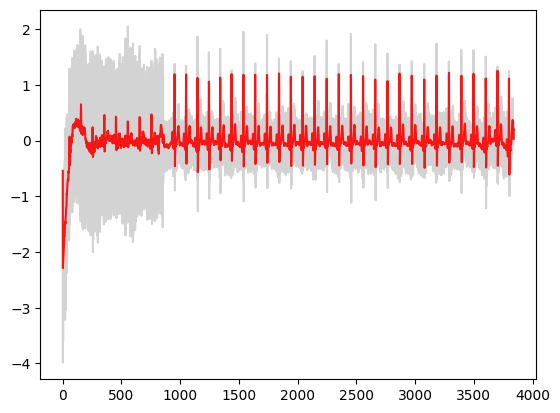

In [25]:
import neurokit2 as nk
import numpy as np

record = np.load(os.path.join(save_dir, 'p01_2.npy'))
fs = 128
signals, info = nk.ecg_process(record, sampling_rate=fs, show = True)
rpeaks = info["ECG_R_Peaks"]
rpeak_amplitudes = ecg[rpeaks]


rri = get_rri(rpeaks, fs)

print("R-peak amplitudes:", rpeak_amplitudes)
print("QRS indices:", rpeaks)
print("R-R intervals (ms):", rri)



In [34]:
from scipy.spatial.distance import squareform, pdist

def rp_plot_warn_style(rri, delay, embedding_dim):
    N= len(rri)
    Nrp = N - (embedding_dim - 1) * delay
    embedded_rri = np.array([rri[i: i + embedding_dim * delay: delay] for i in range(Nrp)])
    distances = squareform(pdist(embedded_rri, metric='euclidean'))
    return distances

In [ ]:
def normalize_to_gray_scale(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    normalized_matrix = (matrix - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero
    return (normalized_matrix*255).astype(np.uint8)

In [17]:
%pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 2.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 466.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-image] [scikit-image]
Note: you may need to restart the kernel to use updated packages.


[7359.375   765.625   757.8125  757.8125  750.      757.8125  789.0625
  781.25    781.25    804.6875  781.25    781.25    804.6875  796.875
  804.6875  812.5     804.6875  812.5     812.5     804.6875  812.5
  828.125   820.3125  828.125   820.3125  812.5     812.5     773.4375
  773.4375]


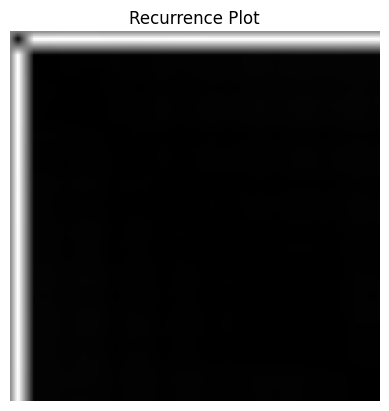

In [35]:
from skimage.transform import resize

img_dim = (224, 224)
print(rri)
distances = rp_plot_warn_style(rri, delay= 3, embedding_dim=3)
rp_gray = normalize_to_gray_scale(distances)
rp_img = resize(rp_gray, img_dim, anti_aliasing=True, preserve_range=True).astype(np.uint8)

plt.imshow(rp_img, cmap='gray')
plt.axis('off')
plt.title("Recurrence Plot")
plt.show()